In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
# x is how much hours which are used to train model, and from x to x+7*24 hours will be forecasted
x = 29880    # x = 29976 (style changing period) or 30000-5*24 = 29880 (peaks water demand period)

In [3]:
df = pd.read_csv('E:\sciebo\Data\pre_processed_Raw_data_demand_KK_freq_60.csv')
df.iloc[:,0] = pd.to_datetime(df.iloc[:,0], infer_datetime_format=True) 
df.iloc[:,0] = df.iloc[:,0].dt.tz_localize(None) 
df.rename(columns = {'datetime_utc':'ds', 'adjusted':'y'}, inplace = True)
df

,ds,y
0,2018-01-15 08:00:00,59.759240
1,2018-01-15 09:00:00,59.226733
2,2018-01-15 10:00:00,84.631849
3,2018-01-15 11:00:00,107.245748
4,2018-01-15 12:00:00,96.690556
...,...,...
30384,2021-07-04 08:00:00,86.438042
30385,2021-07-04 09:00:00,92.873500
30386,2021-07-04 10:00:00,96.202250
30387,2021-07-04 11:00:00,105.203000


In [4]:
df_t = df.loc[0:x]
df_t

,ds,y
0,2018-01-15 08:00:00,59.759240
1,2018-01-15 09:00:00,59.226733
2,2018-01-15 10:00:00,84.631849
3,2018-01-15 11:00:00,107.245748
4,2018-01-15 12:00:00,96.690556
...,...,...
29876,2021-06-13 04:00:00,25.803335
29877,2021-06-13 05:00:00,32.904266
29878,2021-06-13 06:00:00,50.624876
29879,2021-06-13 07:00:00,80.502306


In [5]:
df_f=df.loc[0:x+268]
df_f

,ds,y
0,2018-01-15 08:00:00,59.759240
1,2018-01-15 09:00:00,59.226733
2,2018-01-15 10:00:00,84.631849
3,2018-01-15 11:00:00,107.245748
4,2018-01-15 12:00:00,96.690556
...,...,...
30144,2021-06-24 08:00:00,98.855625
30145,2021-06-24 09:00:00,96.984295
30146,2021-06-24 10:00:00,104.043444
30147,2021-06-24 11:00:00,95.220694


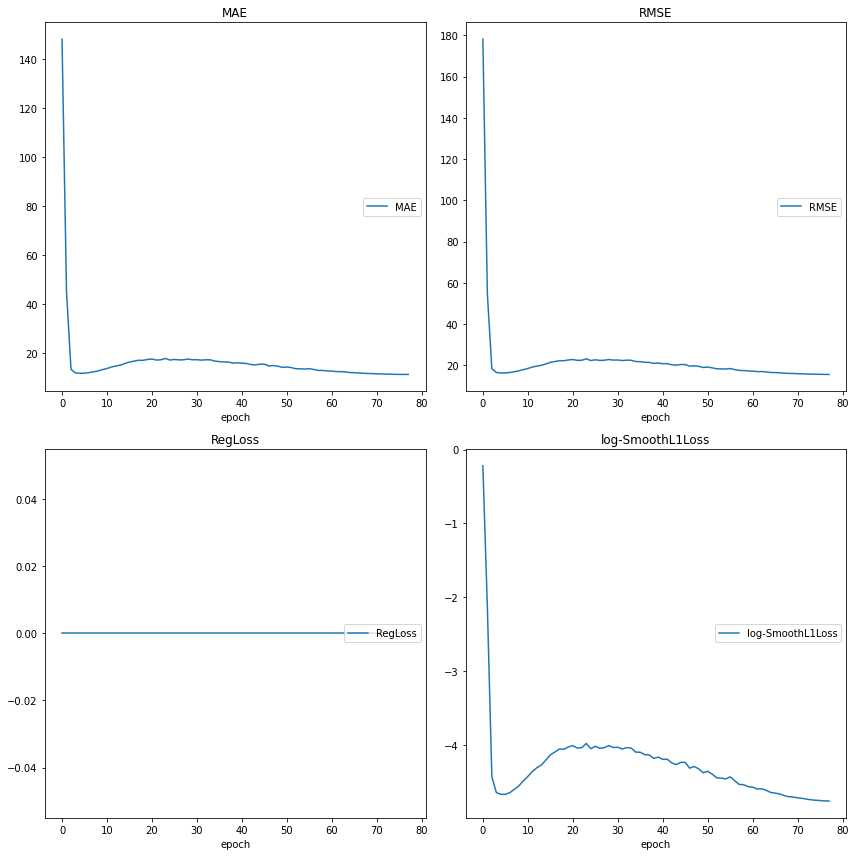

MAE
	MAE              	 (min:   11.413, max:  148.095, cur:   11.413)
RMSE
	RMSE             	 (min:   15.635, max:  178.135, cur:   15.635)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
log-SmoothL1Loss
	log-SmoothL1Loss 	 (min:   -4.754, max:   -0.219, cur:   -4.754)


In [6]:
#df1 = df
m = NeuralProphet()
metrics_try = m.fit(df_t, progress="plot-all")

In [7]:
df_t = df.loc[0:x]
future = m.make_future_dataframe(
                                    df_t, periods=336,n_historic_predictions=True
                                 )
future = future.loc[0:x+168]
future

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.997% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)



,ds,y
0,2018-01-15 08:00:00,59.759240
1,2018-01-15 09:00:00,59.226733
2,2018-01-15 10:00:00,84.631849
3,2018-01-15 11:00:00,107.245748
4,2018-01-15 12:00:00,96.690556
...,...,...
30044,2021-06-20 04:00:00,NaN
30045,2021-06-20 05:00:00,NaN
30046,2021-06-20 06:00:00,NaN
30047,2021-06-20 07:00:00,NaN


In [8]:
file1 = 'E:\sciebo\Data\pre_processed_weather_Barrien_H.csv'                    #
weather = pd.read_csv(file1,parse_dates = True)                                #
rainfall = weather.loc[:,['ID_691_stuendliche_Niederschlagshoehe mm_MA24']]     #
rainfall.columns = ['rainfall']                                                 #
rainfall = rainfall.mask(rainfall>0,1)                                          # devide the rainfall into 0(no) and1 (rain)
sun = weather.loc[:,['ID_691_stuendliche Sonnenscheindauer min']]               #
sun.columns = ['sun']                                                           #
humidity = weather.loc[:,['ID_691_relative Feuchte %_MA24']]                    #
humidity.columns = ['humidity']                                                 #
temperature = weather.loc[:,['ID_691_Lufttemperatur in 2m Hoehe °C_MA24']]     #
temperature.columns = ['temperature']                                           #
weather = pd.concat([rainfall,sun,temperature,humidity],axis=1)                 #
####################################################################################################################
######                                           add sun_duration                                              #####
####################################################################################################################
lastvalue = 0                                                                 
n = 0
newcum = [] 
for _,row in weather.iterrows():
    thisvalue =  row.sun + lastvalue
    if thisvalue == lastvalue:
        n = n+1
        if   0.5<n<1.5 and thisvalue > 600:                  #  The demand's peak comes after one or two hours of sun's peak
            thisvalue = thisvalue + 60                        #  make the sun_duration one hour longer
        elif 1.5<n<3.5 and thisvalue > 600:                  #
            thisvalue = 0.95*thisvalue                        #  The first two hours after demand's peak is close to the peak, so * 0.95
        elif n == 4 and thisvalue > 600:                     #  
             thisvalue = thisvalue * 0.8                      
        else:
            thisvalue = 0
            n = 0
    newcum.append( thisvalue )
    lastvalue = thisvalue
weather['sun_duration'] = newcum
weather["sun_duration"][weather.sun_duration<600]= 600        #  In the decreasing period if the value less than threshold → threshold
####################################################################################################################
####                                             add dry_duration                                              #####
####################################################################################################################
lastvalue = 0
s = 0
newcum = [] 
for _,row in weather.iterrows():
    thisvalue =  row.rainfall
    if thisvalue == 0:
        s = s + 1
    elif thisvalue > 0:  
        s = 0
    newcum.append( s )
weather['dry_duration'] = newcum
weather["dry_duration"][weather.dry_duration>300]= 300
####################################################################################################################
####                            weathert is the weatherdata for training model                                 #####
####                            weatherf is the weatherdata for making forecast                                #####
####################################################################################################################
weathert=weather.loc[0:x]
weatherf=weather.loc[0:x+336]
#####################################################################################################################
####                              data_train is the data frame for training model                            ########
#####################################################################################################################
data_train = pd.concat([df_t,weathert],axis=1)
data_train 

WARNING - (py.warnings._showwarnmsg) - C:\Windows\Temp\ipykernel_9156\2980532672.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather["dry_duration"][weather.dry_duration>300]= 300



,ds,y,rainfall,sun,temperature,humidity,sun_duration,dry_duration
0,2018-01-15 08:00:00,59.759240,0.0,0.0,1.5,80.0,600.0,1
1,2018-01-15 09:00:00,59.226733,0.0,0.0,1.8,80.0,600.0,2
2,2018-01-15 10:00:00,84.631849,0.0,0.0,2.3,79.3,600.0,3
3,2018-01-15 11:00:00,107.245748,0.0,0.0,2.7,78.8,600.0,4
4,2018-01-15 12:00:00,96.690556,0.0,0.0,3.1,78.4,600.0,5
...,...,...,...,...,...,...,...,...
29876,2021-06-13 04:00:00,25.803335,0.0,56.0,14.9,72.0,600.0,164
29877,2021-06-13 05:00:00,32.904266,0.0,57.0,14.7,71.5,600.0,165
29878,2021-06-13 06:00:00,50.624876,0.0,60.0,14.6,70.8,600.0,166
29879,2021-06-13 07:00:00,80.502306,0.0,60.0,14.4,70.0,600.0,167


In [9]:
######################################################################################################################################
####                                          devide the data into day and night                                                   ###
####          In this way, the weather data at night is marked, and then we can make it less effective during night                ###   
######################################################################################################################################
def is_DAY_season(ds):                                                          # add 'sleep' to weaken the parameters' effect at night
    date = pd.to_datetime(ds)                                                   #
    return(date.hour> 5.30 and date.hour<22.30)                                #       
data_train['sleep'] = ~data_train['ds'].apply(is_DAY_season)                    #
data_train.sleep = data_train.sleep.replace({True: 1, False: 0})               #
data_train

,ds,y,rainfall,sun,temperature,humidity,sun_duration,dry_duration,sleep
0,2018-01-15 08:00:00,59.759240,0.0,0.0,1.5,80.0,600.0,1,0
1,2018-01-15 09:00:00,59.226733,0.0,0.0,1.8,80.0,600.0,2,0
2,2018-01-15 10:00:00,84.631849,0.0,0.0,2.3,79.3,600.0,3,0
3,2018-01-15 11:00:00,107.245748,0.0,0.0,2.7,78.8,600.0,4,0
4,2018-01-15 12:00:00,96.690556,0.0,0.0,3.1,78.4,600.0,5,0
...,...,...,...,...,...,...,...,...,...
29876,2021-06-13 04:00:00,25.803335,0.0,56.0,14.9,72.0,600.0,164,1
29877,2021-06-13 05:00:00,32.904266,0.0,57.0,14.7,71.5,600.0,165,1
29878,2021-06-13 06:00:00,50.624876,0.0,60.0,14.6,70.8,600.0,166,0
29879,2021-06-13 07:00:00,80.502306,0.0,60.0,14.4,70.0,600.0,167,0


In [10]:
data_train["humidity"] = data_train["humidity"].mask(data_train.sleep == 1,80)
data_train["temperature"] = data_train["temperature"].mask(data_train.sleep == 1,12)
data_train = data_train.drop(['sleep'],axis=1)
data_train

,ds,y,rainfall,sun,temperature,humidity,sun_duration,dry_duration
0,2018-01-15 08:00:00,59.759240,0.0,0.0,1.5,80.0,600.0,1
1,2018-01-15 09:00:00,59.226733,0.0,0.0,1.8,80.0,600.0,2
2,2018-01-15 10:00:00,84.631849,0.0,0.0,2.3,79.3,600.0,3
3,2018-01-15 11:00:00,107.245748,0.0,0.0,2.7,78.8,600.0,4
4,2018-01-15 12:00:00,96.690556,0.0,0.0,3.1,78.4,600.0,5
...,...,...,...,...,...,...,...,...
29876,2021-06-13 04:00:00,25.803335,0.0,56.0,12.0,80.0,600.0,164
29877,2021-06-13 05:00:00,32.904266,0.0,57.0,12.0,80.0,600.0,165
29878,2021-06-13 06:00:00,50.624876,0.0,60.0,14.6,70.8,600.0,166
29879,2021-06-13 07:00:00,80.502306,0.0,60.0,14.4,70.0,600.0,167


In [11]:
###########################################       devide the data into seasons       ##########################################
######        In this way, the weather data in different seasons is marked,                                              ######
######        and then we can make the weather parameters different effective during different seasons                   ######   
###############################################################################################################################
data_train['ds'] = pd.to_datetime(data_train['ds'])                                      #, format= '%d-%b-%y')
def get_season(row):
    if row['ds'].month >= 3 and row['ds'].month <= 5:
        return 'spring'
    elif row['ds'].month >= 6 and row['ds'].month <= 8:
        return 'summer'
    elif row['ds'].month >= 9 and row['ds'].month <= 11:
        return 'autumn'
    else:
        return 'winter'
data_train['Season'] = data_train.apply(get_season, axis=1)

###############################################################################################################################
####                       make the weather parameters effect differently during different seasons                         ####
###############################################################################################################################
###############################################################################################################################
####                                                                                                                       #### 

my_cond= (data_train['Season'] == 'summer')
replace=0
data_train['dry_duration'].mask(~my_cond,replace,inplace=True)
###############################################################################################################################
####                                       make the dry_duration only effective during summer                              ####
###############################################################################################################################


my_cond= (data_train['Season'] == 'spring') &  (data_train['temperature'] <5) 
replace=5
data_train['temperature'].mask(my_cond,replace,inplace=True)
###############################################################################################################################
####                                      add threshold of temperature during spring with 5                                ####
###############################################################################################################################


my_cond= (data_train['Season'] != 'spring') &  (data_train['temperature'] <12) 
replace=12
data_train['temperature'].mask(my_cond,replace,inplace=True)
###############################################################################################################################
####                                add threshold of temperature during other seasons with 12                              ####
###############################################################################################################################


my_cond= (data_train['Season'] == 'winter')
replace=90
data_train['humidity'].mask(my_cond,replace,inplace=True)
###############################################################################################################################
####                                      make the humidity less effective during winter                                   ####
###############################################################################################################################


my_cond= (data_train['Season'] == 'autumn') 
replace=80
data_train['humidity'].mask(my_cond,replace,inplace=True)
###############################################################################################################################
####                                      make the humidity less effective during autumn                                   ####
###############################################################################################################################


my_cond= (data_train['Season'] == 'winter')
replace=600
data_train['sun_duration'].mask(my_cond,replace,inplace=True)
###############################################################################################################################
####                                      make the sun_duration less effective during winter                               ####
###############################################################################################################################
data_train = data_train.drop(['Season'],axis=1)
data_train

,ds,y,rainfall,sun,temperature,humidity,sun_duration,dry_duration
0,2018-01-15 08:00:00,59.759240,0.0,0.0,12.0,90.0,600.0,0
1,2018-01-15 09:00:00,59.226733,0.0,0.0,12.0,90.0,600.0,0
2,2018-01-15 10:00:00,84.631849,0.0,0.0,12.0,90.0,600.0,0
3,2018-01-15 11:00:00,107.245748,0.0,0.0,12.0,90.0,600.0,0
4,2018-01-15 12:00:00,96.690556,0.0,0.0,12.0,90.0,600.0,0
...,...,...,...,...,...,...,...,...
29876,2021-06-13 04:00:00,25.803335,0.0,56.0,12.0,80.0,600.0,164
29877,2021-06-13 05:00:00,32.904266,0.0,57.0,12.0,80.0,600.0,165
29878,2021-06-13 06:00:00,50.624876,0.0,60.0,14.6,70.8,600.0,166
29879,2021-06-13 07:00:00,80.502306,0.0,60.0,14.4,70.0,600.0,167


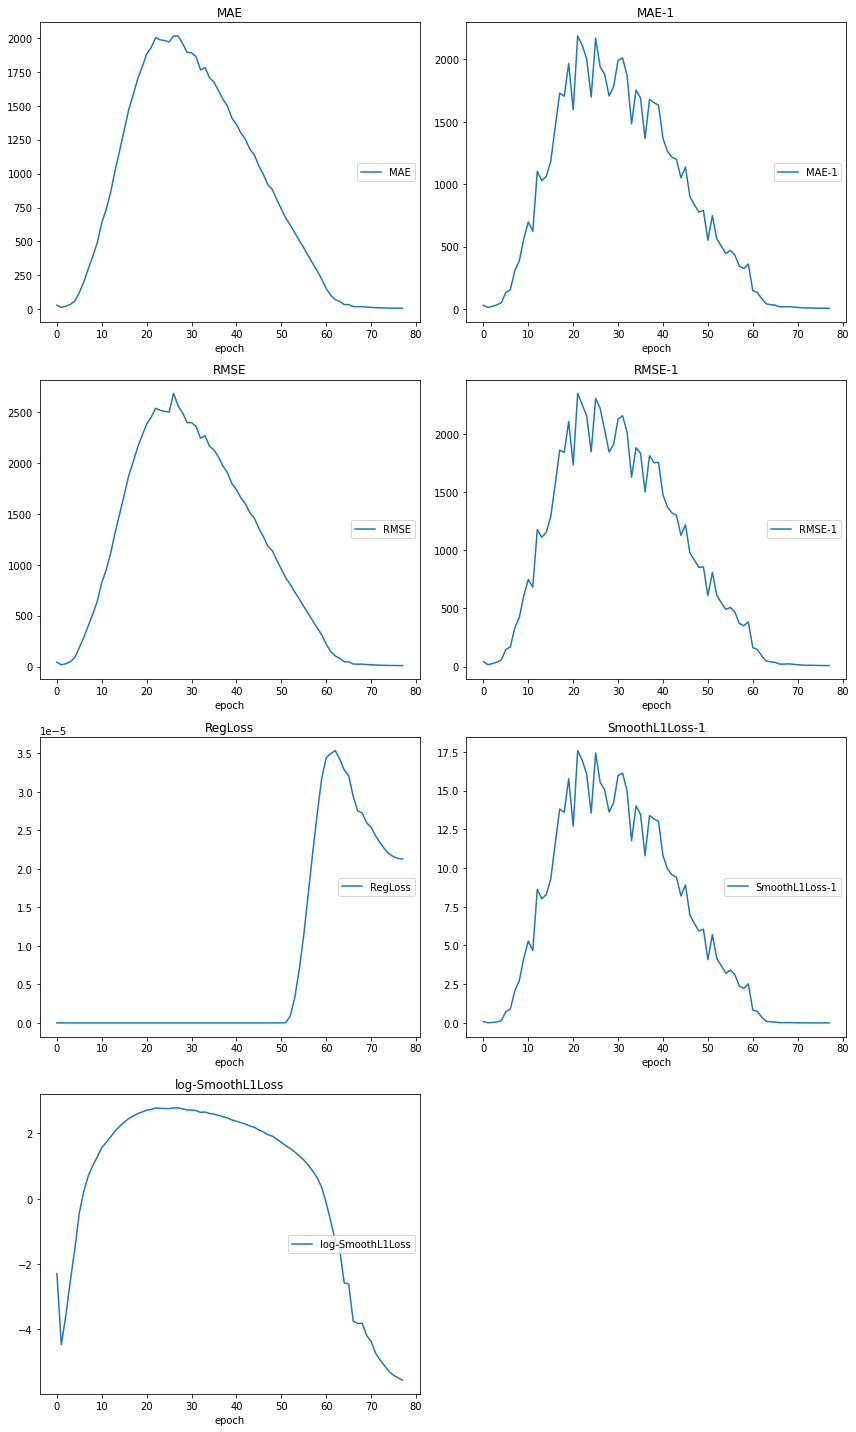

MAE
	MAE              	 (min:    7.439, max: 2013.823, cur:    7.439)
MAE-1
	MAE-1            	 (min:    5.978, max: 2187.090, cur:    5.978)
RMSE
	RMSE             	 (min:   10.593, max: 2681.300, cur:   10.593)
RMSE-1
	RMSE-1           	 (min:    8.268, max: 2352.753, cur:    8.268)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
SmoothL1Loss-1
	SmoothL1Loss-1   	 (min:    0.002, max:   17.583, cur:    0.002)
log-SmoothL1Loss
	log-SmoothL1Loss 	 (min:   -5.561, max:    2.782, cur:   -5.561)


In [12]:
#  the forecast process consiider too much past values of y or yhat .
#  I need to give auto regressor parameter less weight to make a better forecast

m = NeuralProphet( 
                 n_forecasts=24*7,
                 n_lags=24*14, 
                 d_hidden = 2,
                 ar_reg=0.01,
                 #ar_sparsity=0.1,
                 #batch_size = 365*24,
                 learning_rate=1,
#                changepoint_prior_scale = 0.003,
#                seasonality_prior_scale = 0.01,
                 changepoints_range=0.95,
                 n_changepoints=3,
                 daily_seasonality=7 ,yearly_seasonality = 6,weekly_seasonality = 2
#                mcmc_samples=100
                 )
m = m.highlight_nth_step_ahead_of_each_forecast(1)
m.add_future_regressor('rainfall',mode="multiplicative")
m.add_future_regressor('sun',mode="multiplicative")
m.add_future_regressor('temperature',mode="multiplicative")
m.add_future_regressor('humidity',mode="multiplicative")
m.add_country_holidays(country_name="Germany")
m.add_future_regressor('dry_duration',mode="multiplicative")
m.add_future_regressor('sun_duration',mode="multiplicative")
metrics = m.fit(data_train, progress="plot-all")   #_T,validation_df=data_text_T

In [13]:
future['sleep'] = ~future['ds'].apply(is_DAY_season)

future_w = pd.concat([future,weatherf],axis=1)
future_w["humidity"] = future_w["humidity"].mask(future_w.sleep == 1,80)
future_w["temperature"] = future_w["temperature"].mask(future_w.sleep == 1,12)   # if spring, 12 = 5
future_w = future_w.loc[0:x+168]
future_w

,ds,y,sleep,rainfall,sun,temperature,humidity,sun_duration,dry_duration
0,2018-01-15 08:00:00,59.759240,False,0.0,0.0,1.5,80.0,600.0,1
1,2018-01-15 09:00:00,59.226733,False,0.0,0.0,1.8,80.0,600.0,2
2,2018-01-15 10:00:00,84.631849,False,0.0,0.0,2.3,79.3,600.0,3
3,2018-01-15 11:00:00,107.245748,False,0.0,0.0,2.7,78.8,600.0,4
4,2018-01-15 12:00:00,96.690556,False,0.0,0.0,3.1,78.4,600.0,5
...,...,...,...,...,...,...,...,...,...
30044,2021-06-20 04:00:00,NaN,True,1.0,0.0,12.0,80.0,600.0,0
30045,2021-06-20 05:00:00,NaN,True,1.0,0.0,12.0,80.0,600.0,0
30046,2021-06-20 06:00:00,NaN,False,1.0,10.0,22.3,71.8,600.0,0
30047,2021-06-20 07:00:00,NaN,False,1.0,1.0,22.2,72.6,600.0,0


In [14]:
###############################################################################################################################
####                       make the weather parameters effect differently during different seasons                         ####
###############################################################################################################################
future_w['ds'] = pd.to_datetime(future_w['ds'])#, format= '%d-%b-%y')
def get_season(row):
    if row['ds'].month >= 3 and row['ds'].month <= 5:
        return 'spring'
    elif row['ds'].month >= 6 and row['ds'].month <= 8:
        return 'summer'
    elif row['ds'].month >= 9 and row['ds'].month <= 11:
        return 'autumn'
    else:
        return 'winter'
future_w['Season'] = future_w.apply(get_season, axis=1)

my_cond= (future_w['Season'] == 'summer')
replace=0
future_w['dry_duration'].mask(~my_cond,replace,inplace=True)

my_cond= (future_w['Season'] == 'spring') &  (future_w['temperature'] <5) 
replace=5
future_w['temperature'].mask(my_cond,replace,inplace=True)

my_cond= (future_w['Season'] != 'spring') &  (future_w['temperature'] <12) 
replace=12
future_w['temperature'].mask(my_cond,replace,inplace=True)

my_cond= (future_w['Season'] == 'winter')# &  (data_train['temperature'] <12) 
replace=90
future_w['humidity'].mask(my_cond,replace,inplace=True)

my_cond= (future_w['Season'] == 'autumn')# &  (data_train['temperature'] <12) 
replace=80
future_w['humidity'].mask(my_cond,replace,inplace=True)

my_cond= (future_w['Season'] == 'winter')# &  (data_train['temperature'] <12) 
replace=600
future_w['sun_duration'].mask(my_cond,replace,inplace=True)

###############################################################################################################################
####                       make the weather parameters effect differently during day and night                             ####
###############################################################################################################################

future_w["humidity"] = future_w["humidity"].mask(future_w.sleep == 1,80)
future_w["temperature"] = future_w["temperature"].mask(future_w.sleep == 1,12)
future_w["rainfall"] = future_w["rainfall"].mask(future_w.sleep == 1,0)
future_w = future_w.drop(['sleep','Season'],axis=1)
future_w

,ds,y,rainfall,sun,temperature,humidity,sun_duration,dry_duration
0,2018-01-15 08:00:00,59.759240,0.0,0.0,12.0,90.0,600.0,0
1,2018-01-15 09:00:00,59.226733,0.0,0.0,12.0,90.0,600.0,0
2,2018-01-15 10:00:00,84.631849,0.0,0.0,12.0,90.0,600.0,0
3,2018-01-15 11:00:00,107.245748,0.0,0.0,12.0,90.0,600.0,0
4,2018-01-15 12:00:00,96.690556,0.0,0.0,12.0,90.0,600.0,0
...,...,...,...,...,...,...,...,...
30044,2021-06-20 04:00:00,NaN,0.0,0.0,12.0,80.0,600.0,0
30045,2021-06-20 05:00:00,NaN,0.0,0.0,12.0,80.0,600.0,0
30046,2021-06-20 06:00:00,NaN,1.0,10.0,22.3,71.8,600.0,0
30047,2021-06-20 07:00:00,NaN,1.0,1.0,22.2,72.6,600.0,0


INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.997% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.997% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["yhat{}".format(forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["residual{}".format(forecast_lag)] = yhat - df_forecast["y"]

WARNING - (py.warnings._showwarnmsg) - C:\Users\A

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\e

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\e

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\e

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\e

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\e

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\e

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\e

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\e

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast["{}{}".format(comp, forecast_lag)] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\e

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2311: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[comp] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecaster.py:2311: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[comp] = yhat

WARNING - (py.warnings._showwarnmsg) - C:\Users\ASUS\anaconda3\envs\Neuralprophet\lib\site-packages\neuralprophet\forecast

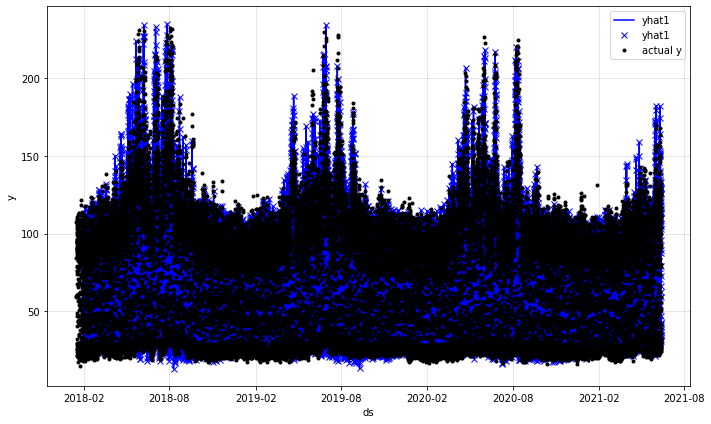

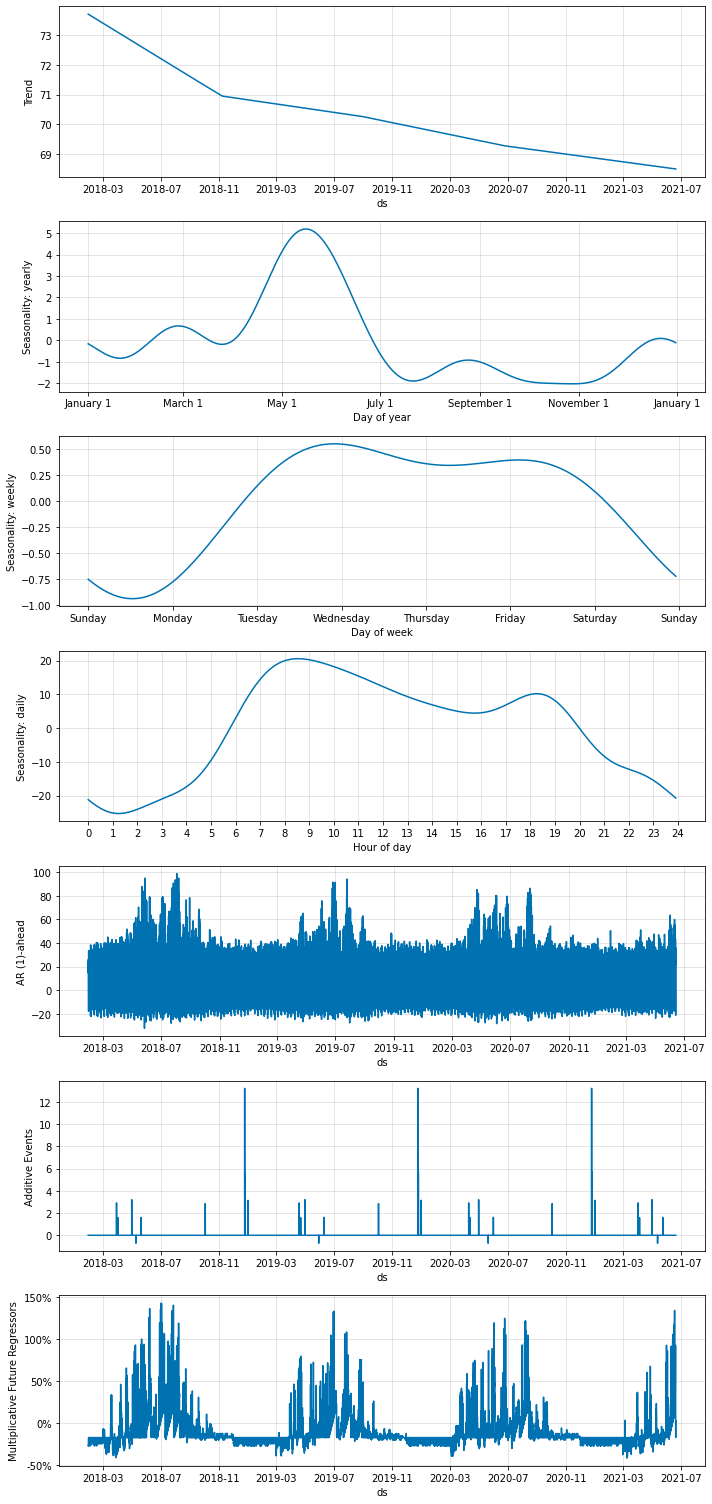

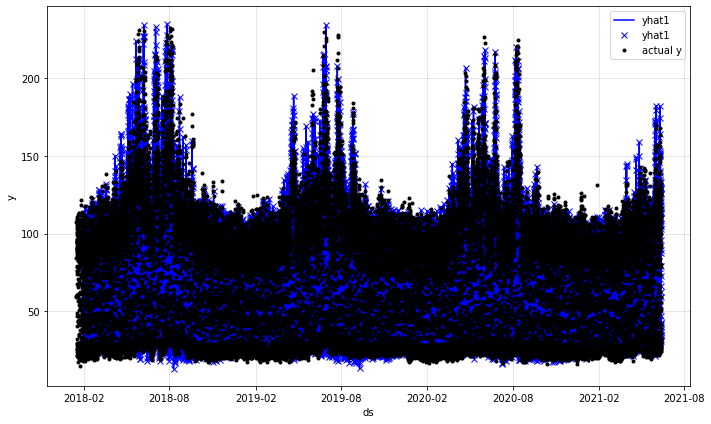

In [15]:
forecast = m.predict(future_w)
fig = m.plot_components(forecast)
m.plot(forecast)  

In [16]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
df_3 = df.loc[x-24*3:x+168]
forecast_3 = forecast.loc[x:x+368]
trace1 = go.Scatter(
                    x = df_3.ds,                          
                    y = df_3.y,                    
                    mode = "lines+markers",                
                    name = "real waterdemand",             
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)'),   
                    )
trace2 = go.Scatter(
                    x = forecast_3.ds,
                    y = forecast_3.yhat7,
                    mode = "lines+markers",                
                    name = "forecast waterdemand 7hours",
                    marker = dict(color = 'rgba(80, 26, 80, 0.8)'),
                    )

data = [trace1, trace2]
layout = dict(
              title = ' forecast and real water demand',            
              xaxis= dict(title= 'time',ticklen= 50,zeroline= True)
              ) 
fig = dict(data = data, layout = layout)
iplot(fig)

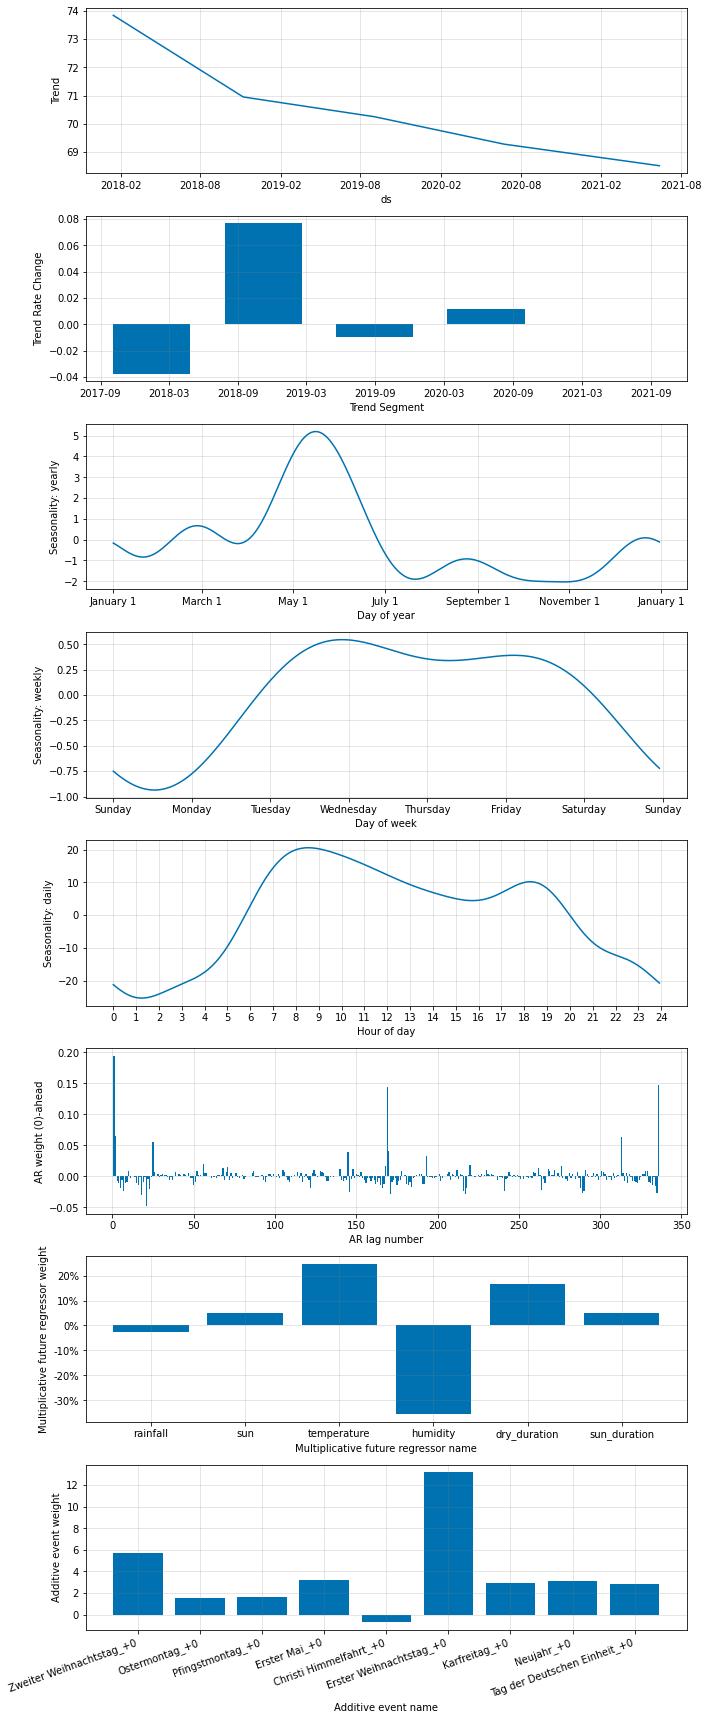

In [17]:
m = m.highlight_nth_step_ahead_of_each_forecast(0)   #we can change (24) to see what happen with ar weight
fig_param = m.plot_parameters()

In [18]:
forecast

,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,...,event_Pfingstmontag,event_Tag der Deutschen Einheit,event_Zweiter Weihnachtstag,future_regressors_multiplicative,future_regressor_dry_duration,future_regressor_humidity,future_regressor_rainfall,future_regressor_sun,future_regressor_sun_duration,future_regressor_temperature
0,2018-01-15 08:00:00,59.759240,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2018-01-15 09:00:00,59.226733,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,2018-01-15 10:00:00,84.631849,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,2018-01-15 11:00:00,107.245748,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,2018-01-15 12:00:00,96.690556,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30044,2021-06-20 04:00:00,NaN,None,None,None,None,None,None,None,None,...,0.0,0.0,0.0,-0.176022,0.0,-34.613777,0.0,0.0,0.0,13.318749
30045,2021-06-20 05:00:00,NaN,None,None,None,None,None,None,None,None,...,0.0,0.0,0.0,-0.176022,0.0,-34.613777,0.0,0.0,0.0,13.318749
30046,2021-06-20 06:00:00,NaN,None,None,None,None,None,None,None,None,...,0.0,0.0,0.0,0.026237,0.0,-27.622818,-3.104755,0.985437,0.0,32.916336
30047,2021-06-20 07:00:00,NaN,None,None,None,None,None,None,None,None,...,0.0,0.0,0.0,0.011696,0.0,-28.304865,-3.104755,0.098544,0.0,32.72607


In [19]:
forecast1 = forecast[x:x+168]
forecast1 

,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,...,event_Pfingstmontag,event_Tag der Deutschen Einheit,event_Zweiter Weihnachtstag,future_regressors_multiplicative,future_regressor_dry_duration,future_regressor_humidity,future_regressor_rainfall,future_regressor_sun,future_regressor_sun_duration,future_regressor_temperature
29880,2021-06-13 08:00:00,111.462113,109.853737,-1.608376,110.024803,-1.43731,113.419746,1.957633,112.138329,0.676215,...,0.0,0.0,0.0,0.143454,19.948854,-25.406172,0.0,4.927185,0.0,17.885176
29881,2021-06-13 09:00:00,NaN,133.470474,NaN,126.606842,NaN,127.127007,NaN,129.228485,NaN,...,0.0,0.0,0.0,0.143887,20.067596,-24.979895,0.0,4.434466,0.0,17.885176
29882,2021-06-13 10:00:00,NaN,None,NaN,135.054459,NaN,130.07811,NaN,130.729858,NaN,...,0.0,0.0,0.0,0.152036,20.18634,-24.809383,0.0,5.32136,0.0,17.69491
29883,2021-06-13 11:00:00,NaN,None,NaN,None,NaN,131.324646,NaN,128.694366,NaN,...,0.0,0.0,0.0,0.155241,20.305086,-24.638872,0.0,5.419903,0.0,17.69491
29884,2021-06-13 12:00:00,NaN,None,NaN,None,NaN,None,NaN,125.017502,NaN,...,0.0,0.0,0.0,0.156223,20.423828,-24.638872,0.0,5.419903,0.0,17.69491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30043,2021-06-20 03:00:00,NaN,None,None,None,None,None,None,None,None,...,0.0,0.0,0.0,-0.176022,0.0,-34.613777,0.0,0.0,0.0,13.318749
30044,2021-06-20 04:00:00,NaN,None,None,None,None,None,None,None,None,...,0.0,0.0,0.0,-0.176022,0.0,-34.613777,0.0,0.0,0.0,13.318749
30045,2021-06-20 05:00:00,NaN,None,None,None,None,None,None,None,None,...,0.0,0.0,0.0,-0.176022,0.0,-34.613777,0.0,0.0,0.0,13.318749
30046,2021-06-20 06:00:00,NaN,None,None,None,None,None,None,None,None,...,0.0,0.0,0.0,0.026237,0.0,-27.622818,-3.104755,0.985437,0.0,32.916336


In [20]:
forecast1=forecast1.filter(regex= 'yhat',axis = 1)
forecast1

,yhat1,yhat2,yhat3,yhat4,yhat5,yhat6,yhat7,yhat8,yhat9,yhat10,...,yhat159,yhat160,yhat161,yhat162,yhat163,yhat164,yhat165,yhat166,yhat167,yhat168
29880,109.853737,110.024803,113.419746,112.138329,112.651428,113.443916,112.79805,113.462616,113.413177,113.300339,...,108.810898,108.704849,108.449585,108.687408,109.353111,108.475952,109.151077,109.314217,110.305305,110.35022
29881,133.470474,126.606842,127.127007,129.228485,128.216415,129.236435,129.203491,128.162155,128.842499,129.075607,...,124.540916,124.646614,124.454109,124.51297,125.041527,125.518059,123.926285,124.712051,125.075668,125.893143
29882,None,135.054459,130.07811,130.729858,132.258682,130.965042,131.805511,132.411331,130.685867,131.683395,...,128.105194,127.284767,127.76503,127.862938,128.151947,127.939903,127.640511,126.953201,127.750954,128.114151
29883,None,None,131.324646,128.694366,129.051346,129.979218,129.046295,129.256088,129.590652,128.74646,...,126.773972,126.64328,126.263847,126.872917,126.996574,126.692307,126.878563,126.648262,125.357124,126.517441
29884,None,None,None,125.017502,122.76165,123.659836,123.928314,123.383888,123.754112,123.962135,...,120.93055,120.459679,120.616425,119.95137,120.613876,120.685684,120.842316,120.466339,120.798058,119.332733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30043,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,26.669029,27.098785,26.074701,25.740452,25.062836,25.105328
30044,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,26.116974,26.714399,24.958656,24.936285,24.955679
30045,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,32.972374,33.926044,32.139858,30.943478
30046,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,62.017994,63.506458,61.028503


In [21]:
for index, row in forecast1.iteritems():
    print(index) # columns names

yhat1
yhat2
yhat3
yhat4
yhat5
yhat6
yhat7
yhat8
yhat9
yhat10
yhat11
yhat12
yhat13
yhat14
yhat15
yhat16
yhat17
yhat18
yhat19
yhat20
yhat21
yhat22
yhat23
yhat24
yhat25
yhat26
yhat27
yhat28
yhat29
yhat30
yhat31
yhat32
yhat33
yhat34
yhat35
yhat36
yhat37
yhat38
yhat39
yhat40
yhat41
yhat42
yhat43
yhat44
yhat45
yhat46
yhat47
yhat48
yhat49
yhat50
yhat51
yhat52
yhat53
yhat54
yhat55
yhat56
yhat57
yhat58
yhat59
yhat60
yhat61
yhat62
yhat63
yhat64
yhat65
yhat66
yhat67
yhat68
yhat69
yhat70
yhat71
yhat72
yhat73
yhat74
yhat75
yhat76
yhat77
yhat78
yhat79
yhat80
yhat81
yhat82
yhat83
yhat84
yhat85
yhat86
yhat87
yhat88
yhat89
yhat90
yhat91
yhat92
yhat93
yhat94
yhat95
yhat96
yhat97
yhat98
yhat99
yhat100
yhat101
yhat102
yhat103
yhat104
yhat105
yhat106
yhat107
yhat108
yhat109
yhat110
yhat111
yhat112
yhat113
yhat114
yhat115
yhat116
yhat117
yhat118
yhat119
yhat120
yhat121
yhat122
yhat123
yhat124
yhat125
yhat126
yhat127
yhat128
yhat129
yhat130
yhat131
yhat132
yhat133
yhat134
yhat135
yhat136
yhat137
yhat138
yhat

In [22]:
def func(x):
    if x.first_valid_index() is None:
        return None
    else:
        return x[x.first_valid_index()]
forecast_text = forecast1.apply(func, axis=1)

In [23]:
forecast_text = pd.DataFrame ( forecast_text, columns = ['y_hat_first']) 
forecast_text

,y_hat_first
29880,109.853737
29881,133.470474
29882,135.054459
29883,131.324646
29884,125.017502
...,...
30043,26.669029
30044,26.116974
30045,32.972374
30046,62.017994


In [45]:
df_3 = df_f.loc[x :x +168]
data_forecast3 = future_w.loc[x:x +168]
forecast_3 = forecast.loc[x:x+168]
trace1 = go.Scatter(
                    x = df_3.ds,                          
                    y = df_3.y,                    
                    mode = "lines+markers",                
                    name = "real waterdemand",             
                    marker = dict(color = 'rgba(16, 112, 2, 0.8)'),   
                    )
trace2 = go.Scatter(
                    x = forecast_3.ds,
                    y = forecast_text.y_hat_first,
                    mode = "lines+markers",               
                    name = "forecast waterdemand first step",
                    marker = dict(color = 'rgba(80, 26, 80, 0.8)'),    
                    )
trace3 = go.Scatter(
                    x = data_forecast3 .ds,
                    y = data_forecast3 .sun_duration/5-120,
                    mode = "lines+markers",               
                    name = "(effects of accumulative sun duration-600)/5",
                    marker = dict(color = 'rgba(180, 26, 80, 0.8)'),
                    )


data = [trace1, trace2, trace3 ]
layout = dict(
              title = 'Neural prophet the effects of accumulative sun duration in test period',            
              xaxis= dict(title= 'time',ticklen= 50,zeroline= True)
              ) 
fig = dict(data = data, layout = layout)
iplot(fig)

In [25]:
y_true = df_f.loc[x:x+72,'y']
y_yhat = forecast_text.loc[x:x+72,'y_hat_first']

In [26]:
y_true                       #three days

29880    111.462113
29881    125.366924
29882    131.916455
29883    130.583170
29884    124.538202
            ...    
29948     38.438864
29949     61.221348
29950    105.286899
29951    134.862771
29952    138.782154
Name: y, Length: 73, dtype: float64

In [27]:
y_yhat

29880    109.853737
29881    133.470474
29882    135.054459
29883    131.324646
29884    125.017502
            ...    
29948     39.250092
29949     56.487068
29950    100.980820
29951    124.273155
29952    128.242203
Name: y_hat_first, Length: 73, dtype: float64

In [28]:
mean_absolute_error(y_true, y_yhat)   # 3  days

8.273470350933755

In [29]:
mean_squared_error(y_true, y_yhat)    # 3  days

116.60777256012327

In [30]:
y_true = df_f.loc[x:x+7*24-1,'y']
y_yhat = forecast_text.loc[x:x+7*24]

In [31]:
mean_absolute_error(y_true, y_yhat)               #  7  days

10.270539680100214

In [32]:
mean_squared_error(y_true, y_yhat)                 # 7 days

211.14192824918732

In [33]:
# sheet = wb.active
# wb.save("E:\\bcd\\bcde.xlsx")
# from openpyxl.utils.dataframe import dataframe_to_rows
# ws = wb.active
# rows = dataframe_to_rows(gtw)
# for r_idx, row in enumerate(rows, 1):
#    for c_idx, value in enumerate(row, 1):
#        ws.cell(row=r_idx, column=c_idx, value=value)
# wb.save('E:\\bcd\\bcde.xlsx')